# Configs

In [1]:
import torch
import numpy as np

import mdtraj as md
import nglview as nv

import openmm as mm
import openmm.unit as unit
from openmm import *
from openmm import app
from openmm.app import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from tqdm import tqdm


In [17]:
model = "tbgcv"
data = "tbg-10n"
k = "200"
repeat_idx = "0"

result_dir = f"../model/{model}/{data}/{k}/"

# Steered MD

In [18]:
def init_simulation(pdb_file_path):
    pdb = PDBFile(pdb_file_path)
    forcefield = app.ForceField("amber99sbildn.xml", "tip3p.xml")
    system = forcefield.createSystem(
		pdb.topology,
		nonbondedMethod=app.PME,
		constraints=app.HBonds,
		ewaldErrorTolerance=0.0005,
	)
    integrator = LangevinIntegrator(
        300 * unit.kelvin,
        0.001 / unit.femtoseconds,
        1 * unit.femtoseconds
    )
    platform = mm.Platform.getPlatformByName("OpenCL")
    properties = {'DeviceIndex': '0', 'Precision': "mixed"}
    
    simulation = Simulation(
        pdb.topology,
        system,
        integrator,
        platform,
        properties
    )        
    
    simulation.context.setPositions(pdb.positions)   
    simulation.minimizeEnergy()
    
    return simulation

def set_simulation(simulation, frame):
    if frame is not None:
        atom_xyz = frame
        atom_list = [Vec3(atom[0], atom[1], atom[2]) for atom in atom_xyz]
        current_state_openmm = unit.Quantity(value=atom_list, unit=unit.nanometer)
        simulation.context.setPositions(current_state_openmm)
    else:
        raise ValueError("Frame is None")
    
    simulation.context.setVelocities(unit.Quantity(value=np.zeros(frame.shape), unit=unit.nanometer/unit.picosecond))
    
    return simulation

def potential_energy(trajectory):
	energy_list = []
	pbb_file_path = f"../../simulation/data/alanine/c5.pdb"
	simulation = init_simulation(pbb_file_path)

	for frame in trajectory:
		try:
			simulation = set_simulation(simulation, frame)
			energy = simulation.context.getState(getEnergy=True).getPotentialEnergy()
			energy_list.append(energy._value)
		except Exception as e:
			print(f"Error in computing energy: {e}")
			energy_list.append(10000)

	return energy_list

In [19]:
# Load path data
smd_traj = np.load(f"{result_dir}/SteeredMD/{repeat_idx}-traj.npy")
print(smd_traj.shape)
path_num, path_length, atom_num, _ = smd_traj.shape

(20, 1000, 22, 3)


In [20]:
path_energy_list = []
for trajectory in tqdm(
	smd_traj,
	desc=f"Computing energy for trajectories"
):
	energy_trajectory = potential_energy(trajectory)
	path_energy_list.append(energy_trajectory)
path_energy_list = np.array(path_energy_list)

all_path_max_energy = np.max(path_energy_list, axis=1).mean()
all_path_final_energy = path_energy_list[:, -1].mean()

Computing energy for trajectories:   0%|          | 0/20 [00:00<?, ?it/s]

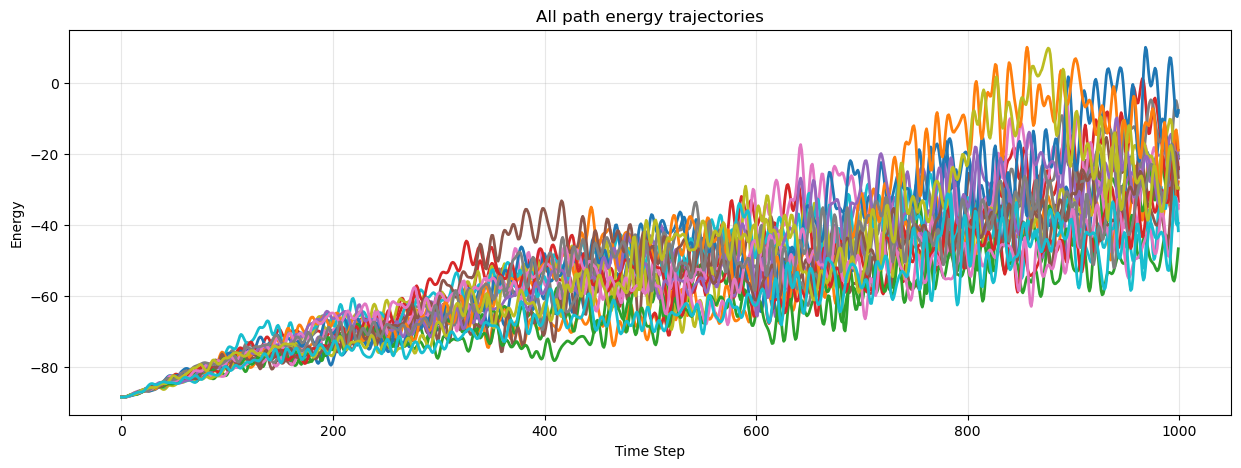

In [24]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for traj_idx in range(path_num):
	ax.plot(
		range(path_length), 
		path_energy_list[traj_idx],
		linewidth=2,
	)
ax.set_xlabel('Time Step')
ax.set_ylabel(f'Energy')
ax.set_title(f'All path energy trajectories')
ax.grid(True, alpha=0.3)

In [25]:
import os
import torch
import numpy as np
from tqdm.auto import tqdm

import mdtraj as md
import nglview as nv

import openmm as mm
import openmm.unit as unit
from openmm import app

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm


def compute_dihedral(positions):
    """http://stackoverflow.com/q/20305272/1128289"""
    def dihedral(p):
        if not isinstance(p, np.ndarray):
            p = p.numpy()
        b = p[:-1] - p[1:]
        b[0] *= -1
        v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
        
        # Normalize vectors
        v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
        b1 = b[1] / np.linalg.norm(b[1])
        x = np.dot(v[0], v[1])
        m = np.cross(v[0], b1)
        y = np.dot(m, v[1])
        
        return np.arctan2(y, x)
    
    angle_list = np.array([
		dihedral(p) for p in tqdm(positions, desc="Dihedrals")
	])
    
    return angle_list

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [0, 4, 5, 6, 8, 10, 14, 15, 16, 18]

In [26]:
last_state = smd_traj[:, 999]
print(last_state.shape)
last_state_phi = compute_dihedral(last_state[:, PHI_ANGLE])
print(last_state_phi>0)

(20, 22, 3)


Dihedrals:   0%|          | 0/20 [00:00<?, ?it/s]

[False False False False False False False False False False False  True
 False False False False False False False False]


In [27]:
hit_idx = np.where(last_state_phi > 0)
print(len(hit_idx[0]))
print(hit_idx)

1
(array([11]),)


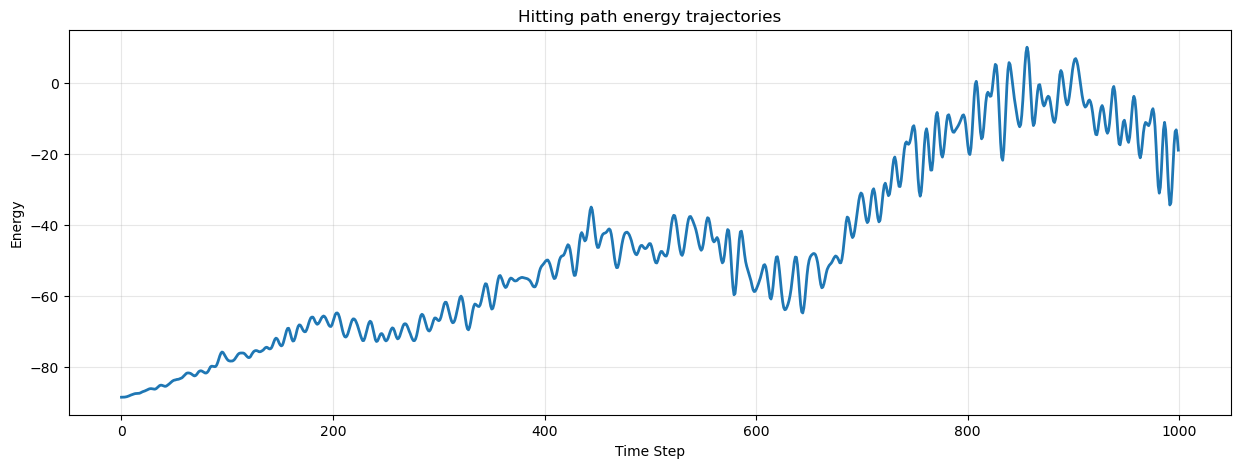

In [28]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in hit_idx[0]:
	ax.plot(
		range(path_length), 
		path_energy_list[i],
		linewidth=2,
	)
ax.set_xlabel('Time Step')
ax.set_ylabel(f'Energy')
ax.set_title(f'Hitting path energy trajectories')
ax.grid(True, alpha=0.3)

In [29]:
print(f"Hit path max energy: {path_energy_list[hit_idx].max()}")
print(f"Hit path final energy: {path_energy_list[hit_idx][:, -1].mean()}")

Hit path max energy: 10.09603927248071
Hit path final energy: -18.867261721334557
